In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

The following codes are translation from the MATLAB ones proposed by Desmond Higham in:

Higham, D. J. (2001), An algorithmic introduction to numerical simulation of stochastic differential equations, SIAM Rev., 43(3), 525–546, doi:10.1137/S0036144500378302.


# Brownian path simulation

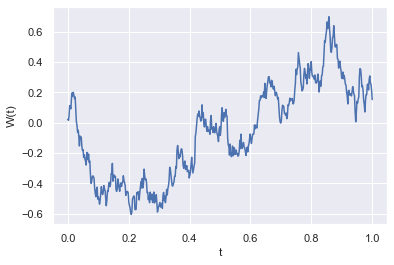

In [15]:
#BPATH1

#Set seed
np.random.seed(42)

#Initialize
T = 1
N = 500
dt = T/N

#Preallocate
dW = np.zeros((N,1))
W = np.zeros((N,1))

#First Approximation outside the loop...
# W(0) = 0 not allowed
dW[0] = np.sqrt(dt)*np.random.normal(0,1)
W[0] = dW[0]


for i in range(1, N):
    dW[i] = np.sqrt(dt)*np.random.normal(0, 1)
    
    # General increment: W[j] = W[j-1] + dW[j]
    W[i] = W[i-1] + dW[i]

plt.plot(np.linspace(0, 1, N), W)
plt.ylabel('W(t)')
plt.xlabel('t')
plt.show()

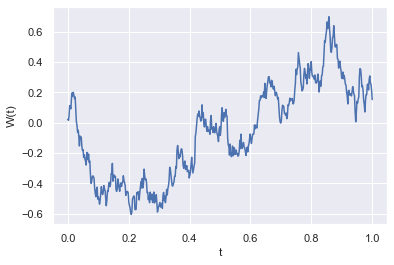

In [29]:
#BPATH2 Brownian path vectorized

#Set seed
np.random.seed(42)

#Initialize
T = 1
N = 500
dt = T/N

#Vectorize
dW = np.sqrt(dt)*np.random.normal(0,1, size = 500).reshape(N, 1)
W = np.cumsum(dW).reshape(N, 1)

plt.plot(np.linspace(0, 1, N), W)
plt.ylabel('W(t)')
plt.xlabel('t')
plt.show()

In [109]:
#BPATH3 Function along a Brownian path

#set seed
np.random.seed(42)

#Initialize
T = 1
N = 500
dt = T/N
t = np.linspace(dt, T, 500)
M = 1000 # Repetitions

#Increments and cumulative sum
dW = np.sqrt(dt)*np.random.normal(0,1, size = (N, M))
W = np.cumsum(dW, axis = 0)
U = np.exp(t.reshape(500,1) + 0.5*W)

#We can add the point t = 0, U(0) = 1
t = np.concatenate(([0],t))
U = np.concatenate((np.ones((1,1000)), U))
Umean = np.mean(U, axis = 1)

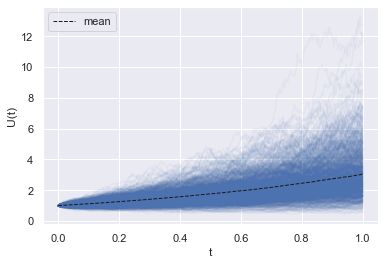

In [110]:
plt.plot(t, U, 'b', alpha = 0.05)
plt.plot(t, Umean,'k--', label = 'mean', linewidth = 1)
plt.legend(loc = 'upper left')
plt.xlabel('t')
plt.ylabel('U(t)')
plt.show()

# Hacker-proof of some Ito Calculus (NOT IN HIGHAM)

Some intereseting properties:

$\sum_{j=0}^{N-1} W(t_j) (W(t_{j+1}) - W(t_j)) = $

$\frac{1}{2} \sum_{j=0}^{N-1} W(t_{j+1})^2 + W(t_{j})^2 -(W(t_{j+1}) - W(t_j))^2$

$\frac{1}{2}(W(T)^2 + W(0)^2 -\sum_{j=0}^{N-1} (W(t_{j+1}) - W(t_j))^2)$

And $\sum_{j=0}^{N-1} (W(t_{j+1}) - W(t_j))^2)$ is supposed to have expected value T and variance of O($\delta t$). Let's see that:

In [133]:
expected_value = np.mean(np.sum(np.diff(W, axis = 0)**2, axis = 0))
variance_calculated = np.var(np.sum(np.diff(W, axis = 0)**2, axis = 0))

print('The expected value {0:8.4f} is close to T: {1:}'.format(expected_value, T))
print('The variance calculated {0:8.4f} is order of dt: {1:}'.format(variance_calculated, dt))

The expected value   0.9990 is close to T: 1
The variance calculated   0.0037 is order of dt: 0.002


In [213]:
#STINT Approximate stochastic intergrals
# Ito and Stratonovich integrals of W dW

np.random.seed(42)

#initialize
T = 1
N = 500
dt = T/N

# One Brownian path
dW = np.sqrt(dt)*np.random.normal(0,1, size = 500)
W = np.cumsum(dW)

# integrals
#Ito
ito = np.sum(np.concatenate(([0],W[0:-1]))*dW)
#stratonovich
strat = np.sum((0.5*(np.concatenate(([0],W[0:-1]))+W) + 0.5*np.sqrt(dt)*np.random.normal(0,1,size = N))*dW)

#error from the limit
itoerr = np.abs(ito - 0.5*(W[-1]**2 - T))
straterr = np.abs(strat - 0.5*W[-1]**2)

print('The Ito integral amounts to {0:8.4f} and the error is {1:8.4f}'.format(ito, itoerr))
print('The Stratonovich integral amounts to {0:8.4f} and the error is {1:8.4f}'.format(strat, straterr))

The Ito integral amounts to  -0.4688 and the error is   0.0195
The Stratonovich integral amounts to  -0.0244 and the error is   0.0361


# Euler-Maruyama Method

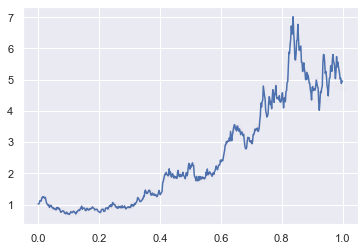

The error using the Euler-Mayurama algorithm with R = 4 is   0.2381


In [297]:
# EM Euler-Maruyama method in linear SDE
# SDE is dX = lambda*X dt + mu*X dW X(0) = X0
# where lambda = 2, mu = 1, X0 = 0
#
# Discretized Brownian patho over [0,1] has dt = 2**-8
# Euler-Matuyama uses timestep R*dt

np.random.seed(42)

lam = 2
mu = 1
X0 = 1
T = 1
N = 2**9
dt = 1/N
dW = np.sqrt(dt)*np.random.normal(0,1, size = N)
W = np.cumsum(dW)

#Solution
Xtrue = X0*np.exp((lam-0.5*mu**2)*np.linspace(dt,T,N)+mu*W)

#Rs = [128, 64, 32, 16, 4, 2, 1]
Rs = [4]
for R in Rs:
    Dt = R*dt
    L = int(N/R)
    Xem = np.zeros((L,1))
    Xtemp = X0
    for j in range(1,L+1):
        Winc = np.sum(dW[(j-1)*R:j*R])
        Xtemp = Xtemp + Dt*lam*Xtemp + mu*Xtemp*Winc
        Xem[j-1] = Xtemp

    plt.plot(np.linspace(0, T, endpoint = True, num = N), Xtrue,'b')
    plt.plot(np.linspace(0, T, num = L+1, endpoint = True), np.concatenate(([X0],Xem.ravel())), 'r--*', alpha = 0.01)
    plt.show()

    emerror = np.abs(Xtrue[-1]-Xem[-1])
    print('The error using the Euler-Mayurama algorithm with R = {1} is {0:8.4f}'.format(emerror[0], R))

In [276]:
Xtrue.shape

(256,)